In [1]:
import time
from pipeline import *
import cv2
import os
from skimage import io

from typing import Counter
import cv2
import numpy as np
from preprocessing import *

In [ ]:
class SVMCharacterRecognizer:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.classifiers = {}  # One-vs-All classifiers
        
    def _preprocess_image(self, image, target_size=(20, 20)):
        """Resize and flatten image to consistent size"""
        # Ensure image is binary
        binary = np.array(image) > 0
        
        # Resize using simple interpolation
        h_ratio = binary.shape[0] / target_size[0]
        w_ratio = binary.shape[1] / target_size[1]
        
        resized = np.zeros(target_size)
        for i in range(target_size[0]):
            for j in range(target_size[1]):
                orig_i = int(i * h_ratio)
                orig_j = int(j * w_ratio)
                resized[i, j] = binary[orig_i, orig_j]
        
        # Flatten and normalize
        return resized.flatten() / 255.0
    
    def _rbf_kernel(self, x1, x2, gamma=0.1):
        """RBF (Gaussian) kernel"""
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    
    class BinarySVM:
        def __init__(self, learning_rate, lambda_param, n_iterations):
            self.lr = learning_rate
            self.lambda_param = lambda_param
            self.n_iterations = n_iterations
            self.w = None
            self.b = None
            
        def fit(self, X, y):
            n_samples, n_features = X.shape
            
            # Initialize weights and bias
            self.w = np.zeros(n_features)
            self.b = 0
            
            # Gradient descent
            for _ in range(self.n_iterations):
                for idx, x_i in enumerate(X):
                    condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                    
                    if condition:
                        self.w -= self.lr * (2 * self.lambda_param * self.w)
                    else:
                        self.w -= self.lr * (2 * self.lambda_param * self.w - 
                                           np.dot(x_i, y[idx]))
                        self.b -= self.lr * y[idx]
        
        def predict(self, X):
            return np.sign(np.dot(X, self.w) + self.b)
    
    def fit(self, X, y):
        """
        Train SVM classifiers using One-vs-All approach
        Args:
            X: List of character images
            y: List of character labels
        """
        # Preprocess all images
        X_processed = np.array([self._preprocess_image(img) for img in X])
        unique_chars = np.unique(y)
        
        # Train one classifier for each character
        for char in unique_chars:
            # Create binary labels (1 for current char, -1 for others)
            binary_labels = np.where(y == char, 1, -1)
            
            # Create and train classifier
            classifier = self.BinarySVM(self.lr, self.lambda_param, self.n_iterations)
            classifier.fit(X_processed, binary_labels)
            
            # Store classifier
            self.classifiers[char] = classifier
    
    def predict(self, image):
        """
        Recognize a single character
        Args:
            image: Character image
        Returns:
            Predicted character and confidence score
        """
        # Preprocess image
        X = self._preprocess_image(image).reshape(1, -1)
        
        # Get predictions from all classifiers
        predictions = {}
        for char, classifier in self.classifiers.items():
            # Get decision value (distance from hyperplane)
            decision_value = np.dot(X, classifier.w) + classifier.b
            predictions[char] = decision_value[0]
        
        # Get best prediction and confidence
        best_char = max(predictions.items(), key=lambda x: x[1])[0]
        
        # Calculate confidence using softmax
        values = np.array(list(predictions.values()))
        exp_values = np.exp(values - np.max(values))
        confidence = exp_values[list(predictions.keys()).index(best_char)] / np.sum(exp_values)
        
        return best_char, confidence

def train_svm_recognizer(train_images, train_labels):
    """
    Train SVM recognizer with sample data
    Args:
        train_images: List of training character images
        train_labels: List of corresponding character labels
    Returns:
        Trained SVMCharacterRecognizer
    """
    recognizer = SVMCharacterRecognizer()
    recognizer.fit(train_images, train_labels)
    return recognizer
    


In [ ]:
def recognize_plate_text(char_images, recognizer):
    """
    Recognize full license plate text
    Args:
        char_images: List of character images from plate
        recognizer: Trained SVMCharacterRecognizer
    Returns:
        Recognized text and average confidence
    """
    text = ""
    confidences = []
    
    for char_img in char_images:
        char, conf = recognizer.predict(char_img)
        text += char
        confidences.append(conf)
    
    avg_confidence = np.mean(confidences) if confidences else 0
    return text, avg_confidence


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

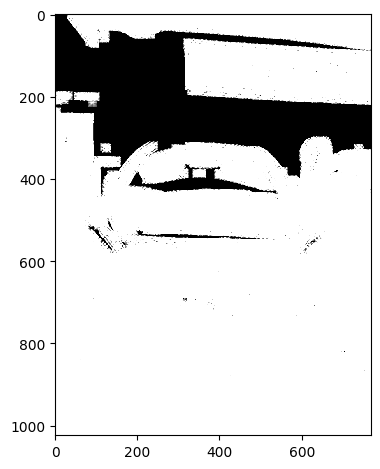

In [5]:
import skimage.io as io
import cv2
import numpy as np
import pytesseract

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
    return binary

# Function to apply Gabor Transform
def apply_gabor_transform(image):
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (3, 5):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                gabor = cv2.getGaborKernel((21, 21), sigma, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
                kernels.append(gabor)
    
    # Combine Gabor filtered images into one
    filtered_images = [cv2.filter2D(image, cv2.CV_8UC3, k) for k in kernels]
    combined_filter = np.max(filtered_images, axis=0)  # Max projection
    return combined_filter

# Function to detect license plate regions
def detect_license_plate_regions(binary_image):
    io.imshow(binary_image)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plate_regions = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if 200 < area < 5000:  # Filter based on area
            x, y, w, h = cv2.boundingRect(contour)
            plate_regions.append((x, y, w, h))
    return plate_regions

# Function to segment characters
def segment_characters(plate_region):
    contours, _ = cv2.findContours(plate_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    character_images = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 20:  # Filter small areas as noise
            x, y, w, h = cv2.boundingRect(contour)
            character_image = plate_region[y:y+h, x:x+w]
            character_images.append(character_image)
    return character_images

# Function to perform OCR on segmented characters
def ocr_characters(character_images):
    recognized_text = ""
    for char_img in character_images:
        # Resize and apply OCR
        char_img_resized = cv2.resize(char_img, None, fx=2, fy=2)
        ret, char_img_binary = cv2.threshold(char_img_resized, 127, 255, cv2.THRESH_BINARY_INV)
        text = pytesseract.image_to_string(char_img_binary, config='--psm 10')
        recognized_text += text.strip()
    return recognized_text

# Main function to process the image
def main(image_path):
    binary_image = preprocess_image(image_path)
    gabor_image = apply_gabor_transform(binary_image)  # Gabor transform for feature enhancement
    
    # Find contours directly on the Gabor-transformed image
    plate_regions = detect_license_plate_regions(gabor_image)
    
    for (x, y, w, h) in plate_regions:
        plate_region = gabor_image[y:y+h, x:x+w]  # Use Gabor image for plate region
        character_images = segment_characters(plate_region)
        recognized_text = ocr_characters(character_images)
        print(f"Recognized License Plate Text: {recognized_text}")

if __name__ == "__main__":
    main("imgs/hyundai.png")  # Replace with your image path

In [15]:
def extractPlate(plate):

    img = plate.copy()

    img = bilateral_filter(img, 25, 25).astype(np.uint8)

    # binary_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # _, binary_image = cv2.threshold(binary_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    canny = cv2.Canny(np.uint8(img), 130, 255, 1)

    # show_images([canny], ["Binary Image"])

    cnts = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(img,[c], 0, (0,255,0), 1)

    show_images([img], ["Detected License Plate"])

    contours = getGreenAreas(img)
    maxX = 0
    maxY = 0
    maxW = 0
    maxH = 0

    # Loop through contours to find the largest rectangle
    for contour in contours:
        # Get the bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        if w > maxW and h > maxH and w/h > 2:
            maxX = x
            maxY = y
            maxW = w
            maxH = h
    plate = img[maxY:maxY+maxH, maxX:maxX+maxW]

    # show_images([img, plate], ["Edgeded License Plate", "Detected License Plate"])

    return plate

def getFillingColor(area):

    filling_colors = []
    # Loop through horizontal lines in the image
    for row in range(area.shape[0]):
        inside_region = False  # Flag to check if we're inside the green-bordered region
        current_color = None
        last_pixel = None
        for col in range(area.shape[1]):
            pixel = tuple(area[row, col])  # Get the BGR color of the current pixel

            if last_pixel == pixel:
                continue

            # Check if the pixel is green
            if pixel == (0, 255, 0):
                # Toggle the inside_region flag when entering or exiting a region
                if inside_region:
                    inside_region = False  # Exiting the region
                else:
                    inside_region = True  # Entering the region
                    current_color = []  # Reset the current color list for the new region
            elif inside_region:
                # Add pixel to the current region's binary color list
                current_color.append(pixel)

            last_pixel = pixel
        
        # Add the region's colors to the filling_colors list
        if current_color:
            filling_colors.extend(current_color)

    # Find the most frequent color among all regions
    most_common_color = Counter(filling_colors).most_common(1)[0][0]

    return most_common_color

# Extract characters from the detected license plate
plate = extractPlate(detected_plate2)

def getCharacters(plate):
    
    contour = getGreenAreas(plate)

    # binary_plate = cv2.cvtColor(plate.copy(), cv2.COLOR_RGB2GRAY)
    # _, binary_plate = cv2.threshold(binary_plate, 120, 255, cv2.THRESH_BINARY)
    # binary_plate = cv2.morphologyEx(255-binary_plate, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # show_images([binary_plate], ["Binary Plate"])

    characters = []
    filling_colors = []
    for c in contour:
        x, y, w, h = cv2.boundingRect(c)
        if w*h > 100:
            area = plate[y:y+h, x:x+w]
            filling_color = getFillingColor(area)
            filling_colors.append(filling_color)

    # Find the most frequent filling color among all returned contours to distinguish between characters and noise
    most_common_color = Counter(filling_colors).most_common(1)[0][0]

    # Loop through the contours to extract the characters
    for c in contour:
        x, y, w, h = cv2.boundingRect(c)

        if w == plate.shape[1] and h == plate.shape[0]:
            continue

        if w*h > 100:
            area = plate[y:y+h, x:x+w]
            filling_color = getFillingColor(area)

            # Getting based on the actual color of the region nor the binary color
            diff = [0,0,0]
            for i in range(3):
                if filling_color[i] > most_common_color[i]:
                    diff[i] = (filling_color[i] - most_common_color[i])**2
                else:
                    diff[i]= (most_common_color[i] - filling_color[i])**2

            distance = math.sqrt(np.sum(diff))
            print(distance, most_common_color, filling_color)
            if distance <= 20:
                print("Character")
                characters.append(area)
                show_images([area], ["Character"])
        

    # return characters

# Get the characters from the extracted license plate
characters = getCharacters(plate)

show_images([detected_plate2, plate], ["Detected License Plate Region", "Detected License Plate"])